# **Tarea 5 - Algoritmos de Rastreo de Objectos**
### Segundo Cuatrimestre del 2020. 
### Carlos Brenes / Ronald Caravaca.

## **Rastreo de Objetos:**
Se tiene un objeto que se ha seleccionado manualmente o por medio de un algoritmo y se requiere rastrear.
## Analogía con los procesos en el cerebro. 
## Problema: 
Se está en un mercado lleno de personas y se necesita detectar y reconocer a un amigo todo el tiempo para no perderlo.
## Procesos que el cerebro realiza:
1. Coordinar con los ojos para detectar humanos con respecto a diferentes objetos en el lugar.
2. Reconocer a la persona de interés en el grupo de humanos y rastrearla continuamente. Habrá momentos en que la persona estará lejos, por lo cual se verá más pequeña. También será oclusionada por otros objetos, y se tendrá que rastrear cuando está completamente o parcialmente visible.

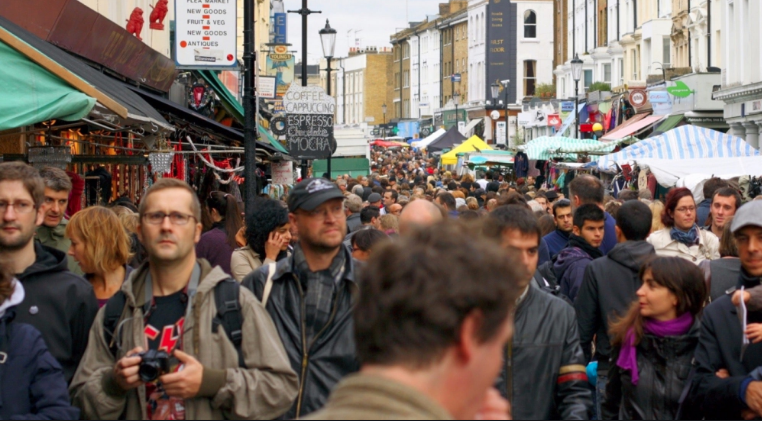

# **Algoritmos de Rastreo**

## 1. Naive Tracker

La idea a la que nos vamos a enfocar aquí es que si hay una clara distinción entre el color del objeto que desea rastrear y el fondo, entonces, idealmente, puede usar tareas básicas de procesamiento de imágenes como ''thresholding'' y espacios de color para rastrear el objeto.

Ahora, intentemos entender el concepto detrás de este rastreador ''ingenuo''. 

![limon1](figures/limon1.jpg)

La imagen anterior es una imagen RGB. El color amarillo del limón estará en algún rango de colores cercano al blanco. Considerando el efecto de la iluminación, no podemos usar solo un valor de color RGB para indicar el color del limón. Entonces, comenzaremos por encontrar un rango de valores de píxeles que muestran solo el limón, y el resto del fondo se convierte en negro. Este proceso no es más que ''thresholding''.

In [23]:
import cv2
import numpy as np


# Create a VideoCapture Object
cap = cv2.VideoCapture("videos/lemon.mp4")


if cap.isOpened() == False:
    print("Error opening video")
    
cv2.namedWindow("Input Video", cv2.WINDOW_NORMAL)
cv2.namedWindow("Output Video", cv2.WINDOW_NORMAL)
cv2.namedWindow("Hue", cv2.WINDOW_NORMAL)

while True:
    # capture frame
    ret, frame = cap.read()

    if ret == False:
        break
    
    # Convert frame to HSV (H stands for hue, S stands for saturation, and V stands for value)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Obtain Hue channel
    h = hsv[:,:,0]

    # Apply thresholding
    hCopy = h.copy()
    h[hCopy>40] = 0
    h[hCopy<=40] = 1

    # Display frame
    cv2.imshow("Input Video", frame)
    cv2.imshow("Output Video", frame*h[:,:,np.newaxis])
    cv2.imshow("Hue", h*255)

    k = cv2.waitKey(2)
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

## 2. **Filtro Kalman (Predecir y Actualizar).** 
- Este rastreador implementa también filtrado de ruido y por lo tanto se conoce como "Filtro". El filtro Kalman fue desarrollado por Rudolf E. Kalman and Richard S. Bucy a inicios de 1960. Se relaciona con conceptos de ingeniería mecánica.

- El filtro Kalman es la solución Bayesiana al problema de, secuencialmente estimar los estados de un sistema dinámico en el cual los procesos de evolución del estado y medición son ambos lineales y Gausianos.

<img src="https://latex.codecogs.com/gif.latex?x_n&space;=&space;F_nx_{n-1}&space;&plus;&space;v_n" title="x_n = F_nx_{n-1} + v_n" />
<img src="https://latex.codecogs.com/gif.latex?y_n&space;=&space;H_nx_n&space;&plus;&space;w_n" title="y_n = H_nx_n + w_n" />

donde $F_n$ es la matriz de transición de estado $D\times D$, $v_n$ es un vector $D\times 1$ de estado de ruido aleatorio Gaussiano ($\mu = 0$ y Matriz de Covarianza $Q_n$). $H_n$ es la matrix de mediciones $M \times D$ y $w_n$ es un vector $M\times 1$ de medición de ruido aleatorio Gaussiano (con media cero y matriz de covarianza $R_n$).

### - Ecuaciones del Filtro Kalman:
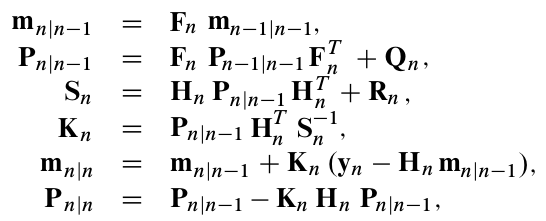
Para n = 1, 2, .... Las ecuaciones $m_{n|n-1}$ y $P_{n|n-1}$ son la etapa de predicción y el resto representan la etapa de actualización.

### - Algoritmo del Filtro Kalman.
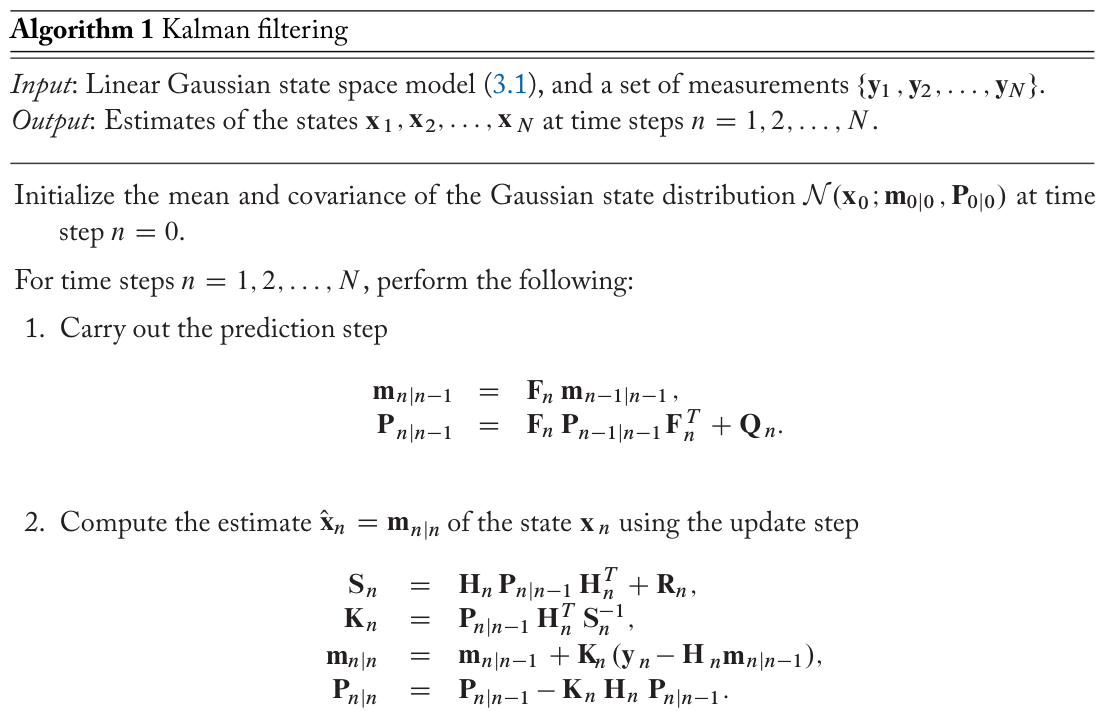



### - Tiene dos pasos principales: a) Predecir y b) Actualizar.

### **- Definiciones:** 
**1) Sistema:** puede ser un barco, una persona, o cualquier objeto a ser rastreado. <br> **2) Estado del Sistema:** es el estado del movimiento del sistema. En otras palabras, la posición y velocidad del objeto.<br> **3) Entradas de control:** son las responsables de cambiar el estado del sistema (ejemplo: aceleración).

Ahora bien, se tiene la ecuacion basica de movimiento:

<img src="https://latex.codecogs.com/gif.latex?x=&space;x&space;&plus;&space;v&space;*&space;dt&space;&plus;&space;1/2&space;*&space;a&space;*&space;dt^2" title="x= x + v * dt + 1/2 * a * dt^2" />

- **x** es la posición actual del objeto, **dt** es el cambio en el tiempo en que se quiere determinar la posición del objeto nuevamente, **v** es la velocidad del objeto, y **a** es la aceleración.
- Si se conoce la velocidad y aceleración del objeto, se puede predecir la posición del objeto en cualquier paso del tiempo. Esto se conoce como el **Paso de Predicción**.

En la vida real, los objetos cambian de posición, velocidad, y aceleración, o podrían estar fuera del marco ("frame") y regresar nuevamente a el. En estos casos, es imposible predecir la posición del objeto. Es ahí cuando el **Paso de Actualización** es necesario: cuando se encuentra nueva información acerca del estado del objeto, se utiliza para inicializar el **Paso de Predicción** y se continúa a partir de ahí con el siguiente proceso. Como se muestra en la figura 1.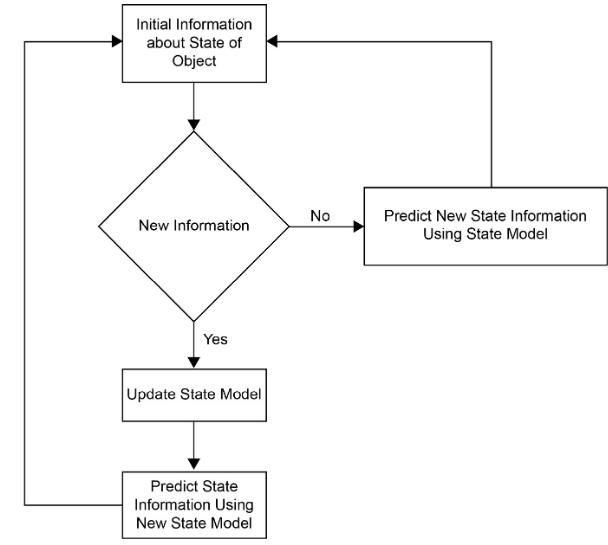 <h3 align="center">**Figura 1. Diagrama de Flujo - Filtro Kalman** [1]</h3>

In [24]:
# %load track_pedestrians.py
import cv2
import numpy as np

OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

class Pedestrian():
    """A tracked pedestrian with a state including an ID, tracking
    window, histogram, and Kalman filter.
    """

    def __init__(self, id, hsv_frame, track_window):

        self.id = id

        self.track_window = track_window
        self.term_crit = \
            (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

        # Initialize the histogram.
        x, y, w, h = track_window
        roi = hsv_frame[y:y+h, x:x+w]
        roi_hist = cv2.calcHist([roi], [0], None, [16], [0, 180])
        self.roi_hist = cv2.normalize(roi_hist, roi_hist, 0, 255,
                                      cv2.NORM_MINMAX)

        # Initialize the Kalman filter.
        self.kalman = cv2.KalmanFilter(4, 2)
        self.kalman.measurementMatrix = np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0]], np.float32)
        self.kalman.transitionMatrix = np.array(
            [[1, 0, 1, 0],
             [0, 1, 0, 1],
             [0, 0, 1, 0],
             [0, 0, 0, 1]], np.float32)
        self.kalman.processNoiseCov = np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]], np.float32) * 0.03
        cx = x+w/2
        cy = y+h/2
        self.kalman.statePre = np.array(
            [[cx], [cy], [0], [0]], np.float32)
        self.kalman.statePost = np.array(
            [[cx], [cy], [0], [0]], np.float32)

    def update(self, frame, hsv_frame):

        back_proj = cv2.calcBackProject(
            [hsv_frame], [0], self.roi_hist, [0, 180], 1)

        ret, self.track_window = cv2.meanShift(
            back_proj, self.track_window, self.term_crit)
        x, y, w, h = self.track_window
        center = np.array([x+w/2, y+h/2], np.float32)

        prediction = self.kalman.predict()
        estimate = self.kalman.correct(center)
        center_offset = estimate[:,0][:2] - center
        self.track_window = (x + int(center_offset[0]),
                             y + int(center_offset[1]), w, h)
        x, y, w, h = self.track_window

        # Draw the predicted center position as a blue circle.
        cv2.circle(frame, (int(prediction[0]), int(prediction[1])),
                   4, (255, 0, 0), -1)

        # Draw the corrected tracking window as a cyan rectangle.
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 255, 0), 2)

        # Draw the ID above the rectangle in blue text.
        cv2.putText(frame, 'ID: %d' % self.id, (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0),
                    1, cv2.LINE_AA)

def main():

    cap = cv2.VideoCapture('pedestrians.avi')

    # Create the KNN background subtractor.
    bg_subtractor = cv2.createBackgroundSubtractorKNN()
    history_length = 20
    bg_subtractor.setHistory(history_length)

    erode_kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (3, 3))
    dilate_kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (8, 3))

    pedestrians = []
    num_history_frames_populated = 0
    while True:
        grabbed, frame = cap.read()
        if (grabbed is False):
            break

        # Apply the KNN background subtractor.
        fg_mask = bg_subtractor.apply(frame)

        # Let the background subtractor build up a history.
        if num_history_frames_populated < history_length:
            num_history_frames_populated += 1
            continue

        # Create the thresholded image.
        _, thresh = cv2.threshold(fg_mask, 127, 255,
                                  cv2.THRESH_BINARY)
        cv2.erode(thresh, erode_kernel, thresh, iterations=2)
        cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

        # Detect contours in the thresholded image.
        if OPENCV_MAJOR_VERSION >= 4:
            # OpenCV 4 or a later version is being used.
            contours, hier = cv2.findContours(
                thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            # OpenCV 3 or an earlier version is being used.
            # cv2.findContours has an extra return value.
            # The extra return value is the thresholded image, which
            # is unchanged, so we can ignore it.
            _, contours, hier = cv2.findContours(
                thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Draw green rectangles around large contours.
        # Also, if no pedestrians are being tracked yet, create some.
        should_initialize_pedestrians = len(pedestrians) == 0
        id = 0
        for c in contours:
            if cv2.contourArea(c) > 500:
                (x, y, w, h) = cv2.boundingRect(c)
                cv2.rectangle(frame, (x, y), (x+w, y+h),
                              (0, 255, 0), 1)
                if should_initialize_pedestrians:
                    pedestrians.append(
                        Pedestrian(id, hsv_frame,
                                   (x, y, w, h)))
            id += 1

        # Update the tracking of each pedestrian.
        for pedestrian in pedestrians:
            pedestrian.update(frame, hsv_frame)

        cv2.imshow('Pedestrians Tracked', frame)

        k = cv2.waitKey(10)
        if k == 27:  # Escape
            break


if __name__ == "__main__":
    main()
    cv2.destroyAllWindows()


## **2. Meanshift – Filtro Buscador de Densidad**

Mean shift fue propuesto en 1975 por Fukunaga y Hostetler. Es un proceso iterativo, no paramétrico que desplaza cada dato a un máximo local de la función de densidad.
Se utiliza para rastreo de objetos, segmentación de images y agrupamiento.
- Sean los datos un conjunto finito $S$ embebido en un espacio euclidiano $X$ de $d$ dimensiones.
- Sea $T \subset X$ un conjunto finito producido por un procedimiento iterativo.

**Filtro Meanshift (Desplazamiento promedio)** es intuitivo y fácil de comprender. Se enfoca en un principio muy simple - "Ir a donde la mayoría va".
En la figura 2, el **Filtro Meanshift** sigue el objeto a ser rastreado (círculo punteado) y puede identificar y rastrear el objecto con base a la densidad de puntos.
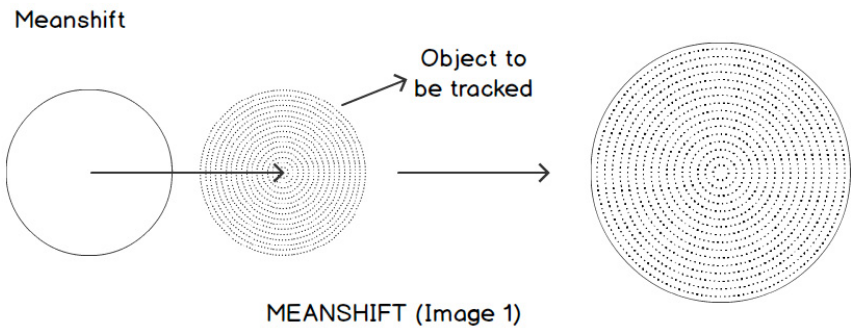 <h3 align="center">**Figura 2. Proceso Básico de Meanshift** [1]</h3>


En la figura 3, se observa que el **"Filtro Meanshift"** busca el "Modo" (a pesar de esto tiene la palabra "Promedio". Esto quiere decir que el filtro rastrea donde la mayor parte de los puntos están. Es así como puede rastrear objetos.

El objeto a rastrear parece un gráfico de dispersión altamente denso y cuando el gráfico de dispersión se mueve un marco, el filtro **"Meanshift"** lo sigue y por lo tanto rastrea el objeto:
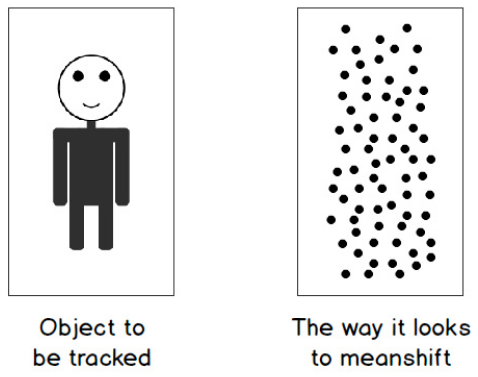 <h3 align="center">**Figura 3. ¿Cómo se considera el objeto a rastrear por el algoritmo "Meanshift"?** [1]</h3> <br>
La ventaja de este algoritmo es que solo "observa" el "Modo", no requiere que se ajuste un parámetro específico.

En la práctica, se procesan objetos presentes en la imágenes. Por lo tanto, para moverse de una simple imagen de un objeto a una **Función de densidad (Modo)**, se necesita realizar un **pre-procesado**. Una forma de realizarlo es:
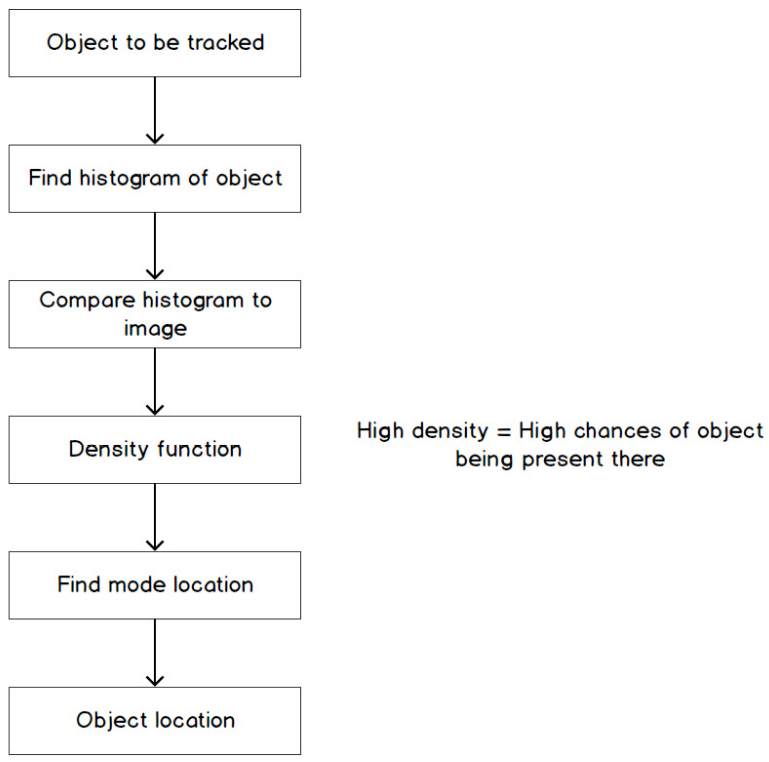<h3 align="center">**Figura 4. Conversión de un Objeto a una Función de Densidad** [1]</h3> <br>
- Se obtiene un histograma del objeto. El cual se utiliza para comparar el objeto a una nueva imagen.
- El resultado obtenido es un Función de Densidad (una alta densidad significa que hay una gran probabilidad de que el objeto estará presente en esa localización.
- Para determinar ¿dónde el objeto está presente?, se tiene que determinar el punto de valor mayor de la función de densidad (este es el Modo).

In [25]:
import cv2
import numpy as np

In [48]:
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture("figures/people.mp4")

# Capture several frames to allow the camera's autoexposure to adjust.
for i in range(10):
    success, frame = cap.read()
if not success:
    exit(1)

In [49]:
# Define an initial tracking window in the center of the frame.
frame_h, frame_w = frame.shape[:2]
w = frame_w//8
h = frame_h//8
x = frame_w//2 - w//2
y = frame_h//2 - h//2
track_window = (x, y, w, h)

In [50]:
# Calculate the normalized HSV histogram of the initial window.
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = None
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
normaliz = cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

In [51]:
# Define the termination criteria:
# 10 iterations or convergence within 1-pixel radius.
term_crit = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

In [52]:
success, frame = cap.read()
while success:

    # Perform back-projection of the HSV histogram onto the frame.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_proj = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    # Perform tracking with MeanShift.
    num_iters, track_window = cv2.meanShift(
        back_proj, track_window, term_crit)

    # Draw the tracking window.
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    cv2.imshow('back-projection', back_proj)
    cv2.imshow('meanshift', frame)

    k = cv2.waitKey(20)
    if k == 27:  # Escape
        break

    success, frame = cap.read()
cv2.destroyAllWindows()

## **3. CAMshift – Meanshift Contínuamente Adaptado**
- **CAMshift** es una modificación de "Meanshift" que resuelve el problema de este algoritmo - variación de escala. 
- **Meanshift** falla si la escala del objeto cambia. Por ejemplo acercar o alejarse de una cámara resulta en una variación de la escala de la imagen.
- **Meanshift** no da buenos resultados porque observa el modo en una ventana de tamaño fijo.
- **CAMshift** utiliza el estimado del modo para encontrar las nuevas dimensiones de la ventana y entonces usa la nueva ventana para encontrar el modo.
- El proceso continua hasta que se alcanza la convergencia, lo que significa que el "Modo" detiene su movimiento.
- Ambos algoritmos (Meanshift y CAMshift) depende de la convergencia.
- Utilizan técnicas iterativas, por lo tanto no encuentran el objeto en un paso, los algoritmos dan respuestas iterativas intermedias que cambian posteriormente hasta que la localización final del objecto es alcanzada.
- La diferencia principal entre **"Meanshift"** y **"CAMshift"** es que mientras el "Meanshift" avanza con las iteraciones manteniendo el mismo tamaño de ventana, "CAMshift" varía el tamaño de la ventana, según el resultado intermedio obtenido, y por lo tanto evita problemas causados por la variación de escala. <br>
En la figura 5, no hay variación en el tamaño de la ventana-
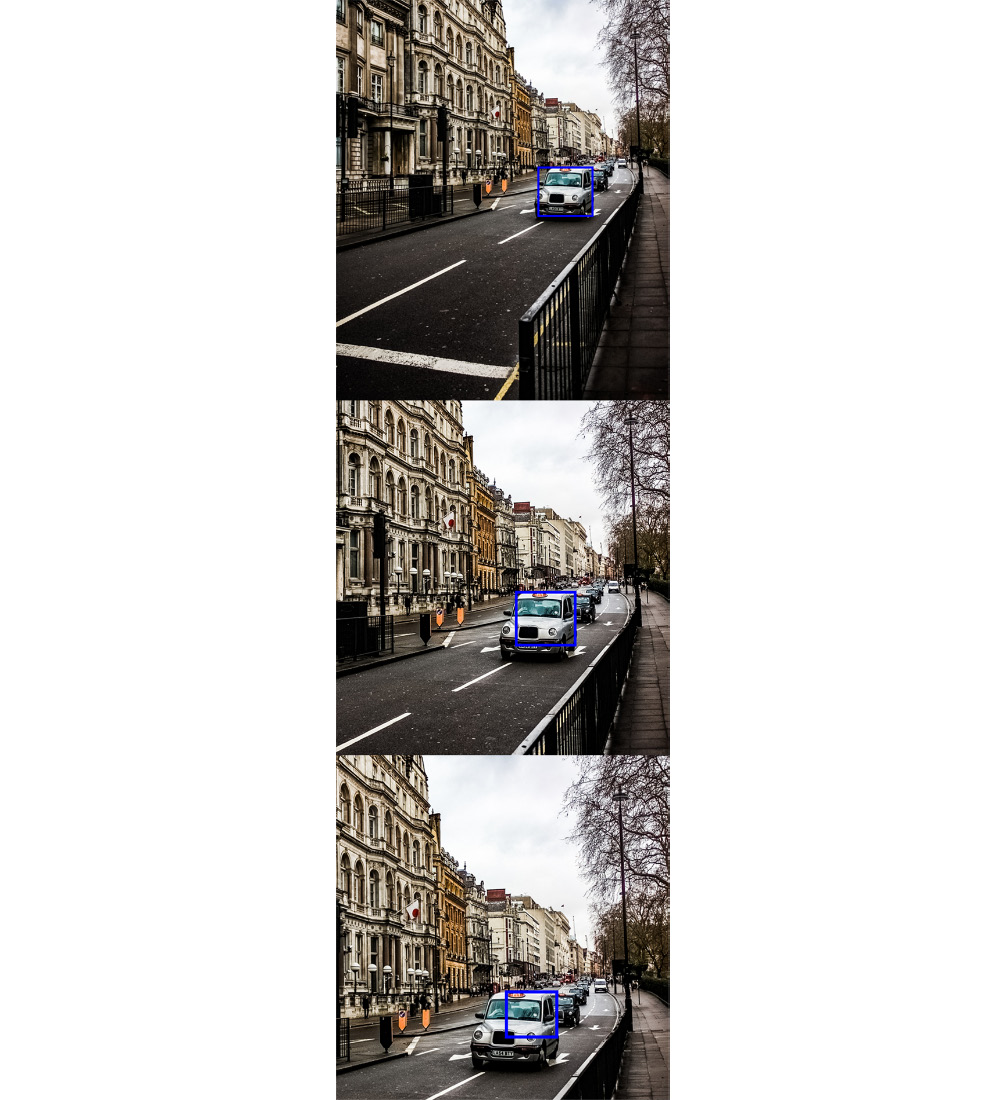<h3 align="center">**Figura 5. Salida del Algoritmo "MEANshift** [1]</h3> <br>

Nótese la variación en el tamaño de la ventana en la salida del Algoritmo CAMshift como se muestra en la figura 6. <br>
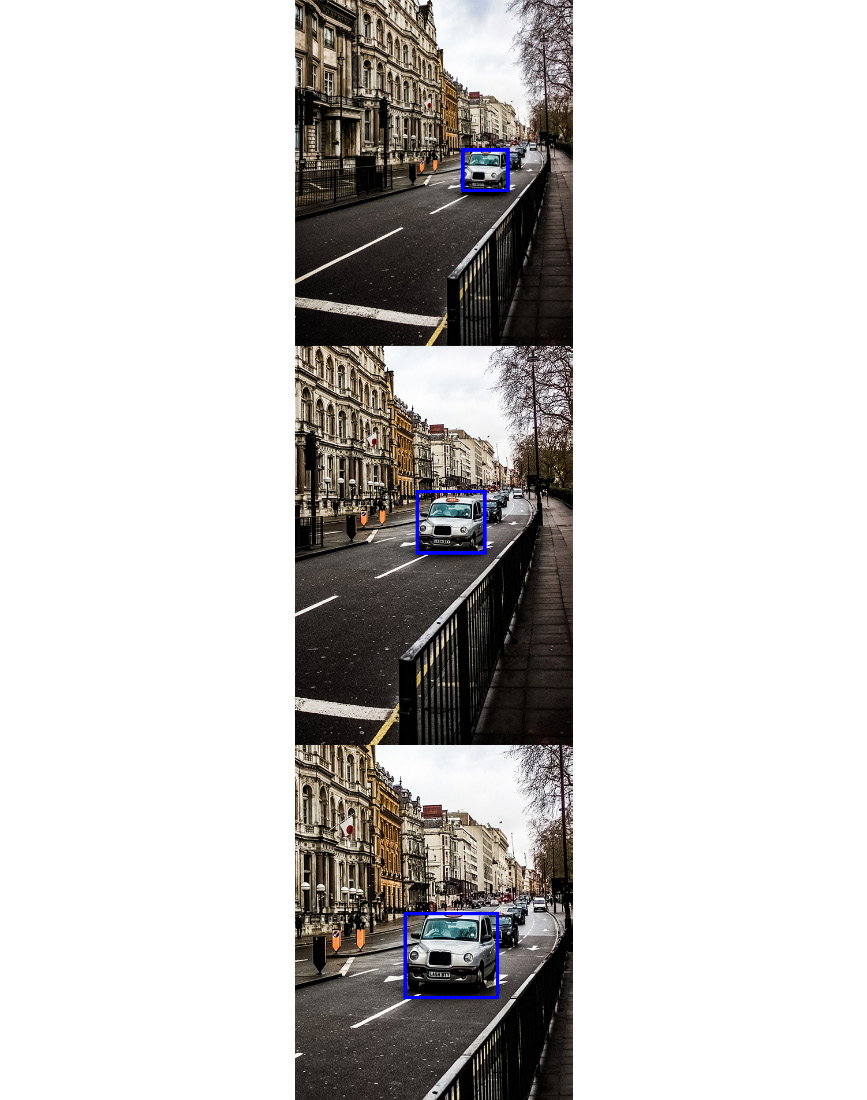 <h3 align="center">**Figura 6. Salida del Algoritmo CAMshift** [1]</h3> <br>

In [58]:
import cv2
import numpy as np

In [59]:
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture("figures/people.mp4")

In [60]:
# Capture several frames to allow the camera's autoexposure to adjust.
for i in range(10):
    success, frame = cap.read()
if not success:
    exit(1)

In [61]:
# Define an initial tracking window in the center of the frame.
frame_h, frame_w = frame.shape[:2]
w = frame_w//8
h = frame_h//8
x = frame_w//2 - w//2
y = frame_h//2 - h//2
track_window = (x, y, w, h)

In [62]:
# Calculate the normalized HSV histogram of the initial window.
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = None
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Define the termination criteria:
# 10 iterations or convergence within 1-pixel radius.
term_crit = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

In [63]:
success, frame = cap.read()
while success:

    # Perform back-projection of the HSV histogram onto the frame.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_proj = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    # Perform tracking with CamShift.
    rotated_rect, track_window = cv2.CamShift(
        back_proj, track_window, term_crit)

    # Draw the tracking window.
    box_points = cv2.boxPoints(rotated_rect)
    box_points = np.int0(box_points)
    cv2.polylines(frame, [box_points], True, (255, 0, 0), 2)

    cv2.imshow('back-projection', back_proj)
    cv2.imshow('camshift', frame)

    k = cv2.waitKey(10)
    if k == 27:  # Escape
        break

    success, frame = cap.read()
    
cv2.destroyAllWindows()

## **4. OpenCV API de Rastreo de Objetos**
- La documentación del API se encuentra en: https://docs.opencv.org/4.2.0/d9/df8/group__tracking.html.
- Algoritmos para el rastreo de Objetos:
4.1. CSRT: ```cv2.TrackerCSRT```

4.2. KCF ("Kernelized Correlation Filter"): ```cv2.TrackerKCF```

4.4. MOSSE ("Minimum Output Sum of Squared Error"): ```cv2.TrackerMOSSE```

4.5. "Median Flow": ```cv2.TrackerMedianFlow```

4.6. MIL "Multiple Instance Learning": ```cv2.TrackerMIL```

4.7. Rastreador "Boosting": ```cv2.TrackerBoosting```

4.8. Rastreador GOTURN: ```cv2.TrackerGOTURN```

4.5. TLD ("Tracking, Learning, and Detection"): ```cv2.TrackerTLD```

Nota: Todos estos rastreadores tienen la misma clase padre - ```cv::Tracker```. Tienen el formato: ```cv2.Tracker<Nombre del Rastreador>```.


### Proceso para usar los rastreadores (Figura 7):
### 1. Definir el rastreador a usar. Es el paso más importante ya que decidirá el desempeño del programa. La selección del rastreador se define con base a: Desempeño del rastreador, incluyendo oclusión, variación de escala, etc.
### 2. Crear el objeto del rastreador por medio de la función: ```tracker = cv2.Tracker<TRACKER_NAME>_create()```. Por ejemplo: ```cv2.TrackerKCF_create()```.
### 3. Definir el objeto a rastrear. Esto se hace al definir el "bounding box" alrededor del objecto. Normalmente se utiliza la función: ```cv2.SelectROI```.
### 4. Se inicializa el rastreador. Durante el proceso, el rastreador necesita dos parámetros: el "bounding box" y el cuadro en donde el "bounding box" está especificada. Se utiliza el primer marco. Para inicializar el rastreador, se usa ```tracker.init(image, bbox)```, donde "image" es el marco, y bbox es el "bounding box" alrededor del objeto.
### 5. Se itera sobre cada marca del video donde se rastrea el objeto y se actualiza el rastreador por medio de la función ```tracker.update(image)```, donde "image" es el cuadro actual donde se busca encontrar el objeto. La función "update" retorna dos valores - una bandera de éxito y el "bounding box". Si el rastreador no es capaz de encontrar el objeto, la bandera de éxito será "Falsa". Si se encuentra el objecto, el "bounding box", el "bounding box" indicará ¿dónde está el objeto presente en la imagen?
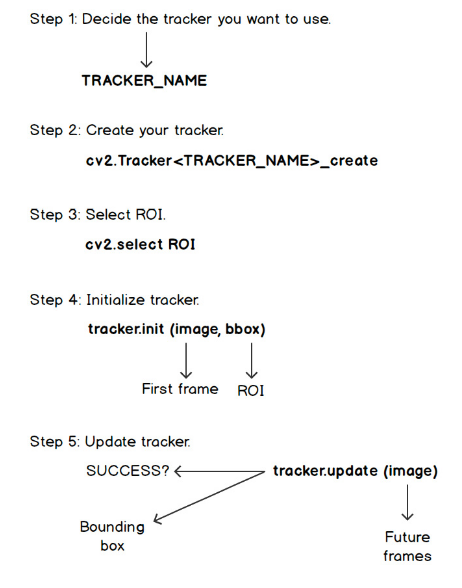 <h3 align="center">**Figura 7. Rastreador de Objetos** [1]</h3> <br>

In [1]:
# Import modules
import cv2
import numpy as np

In [18]:
# Create a VideoCapture Object
video = cv2.VideoCapture("figures/people.mp4")

In [19]:
# Check if video opened successfully
if video.isOpened() == False:
    print("Could not open video!")

In [20]:
# Read first frame
ret, frame = video.read()

In [21]:
# Check if frame is read successfully
if ret == False:
    print("Cannot read video")

In [22]:
#cv2.imshow("First Frame",frame)
#cv2.waitKey(0)
#cv2.imwrite("firstFrame.png", frame)

In [ ]:
# Specify the initial bounding box
bbox = cv2.selectROI(frame)
print(bbox)
cv2.destroyAllWindows()

In [11]:
#tracker = cv2.TrackerCSRT_create()
#tracker = cv2.TrackerKCF_create()
# tracker = cv2.TrackerMOSSE_create()
tracker = cv2.TrackerMedianFlow_create()
#tracker = cv2.TrackerMIL_create()
#tracker = cv2.TrackerTLD_create()

In [12]:
# Initialize tracker
ret = tracker.init(frame,bbox)

In [13]:
# Create a new window where we will display
# the results
cv2.namedWindow("Tracker")
# Display the first frame
cv2.imshow("Tracker",frame)

In [14]:
while True:
    
    # Read next frame
    ret, frame = video.read()
    
    # Check if frame was read
    if ret == False:
        break
    
    # Update tracker
    found, bbox = tracker.update(frame)
    
    # If object found, draw bbox
    if found:
        # Top left corner
        topLeft = (int(bbox[0]), int(bbox[1]))
        # Bottom right corner
        bottomRight = (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3]))
        # Display bounding box
        cv2.rectangle(frame, topLeft, bottomRight, (0,0,255), 2)
    else:
        # Display status
        cv2.putText(frame, "Object not found", (20,70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255), 2)
        
    # Display frame
    cv2.imshow("Tracker",frame)
    k = cv2.waitKey(5)
    if k == 27:
        break
cv2.destroyAllWindows()

<h3 align="center"> Tabla 1. Comparación de Algoritmos Rastreadores de Objetos. </h3>

| Rastreador  	| Ventajas                                                                                                                  	| Desventajas                                                                                                                                               	|
|-------------	|---------------------------------------------------------------------------------------------------------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------	|
| CSRT        	| Alta exactitud                                                                                                            	| Bajos fps(~20-30 fps).                                                                                                                                    	|
| KCF         	| Buena exactitud y velocidad                                                                                               	| Mal desempeño en oclusiones                                                                                                                               	|
| MOSSE       	| Rastrea objetos "in/out"<br>Alto desempeño de velocidad (fps)<br>Buen desempeño a pesar de cambios de luz y deformaciones 	| Está atrás en exactitud y desempeño con respecto a "GOTURN"<br>Falla en variaciones de escala                                                             	|
| Median Flow 	| Excelente rastreador e identifica cuando el rastreo falla                                                                 	| No tiene buen desempeño en oclusiones.                                                                                                                    	|
| MIL         	| Buen desempeño<br>Trabaja bien cuando hay oclusiones parciales                                                            	| No trabaja bien con oclusiones y el objeto<br>no se rastrea completamente                                                                                 	|
| Boosting    	| -                                                                                                                         	| Algoritmo muy antiguo.                                                                                                                                    	|
| GOTURN      	| Más rápido que los otros algoritmos<br>Buen desempeño a pesar de cambios de luz y deformaciones                           	| No recomendado en situaciones de oclusión.<br>No funciona bien con versiones de OpenCV > 3.4.1<br>Requiere el ```caffemodel``` y archivos ```prototxt```  	|
| TLD         	| Mejor desempeño cuando hay oclusiones y variaciones de escala                                                             	| Tendencia a detectar objeto cuando <br>no está presente (falso positivo)     

### **Bibliografía:**

### [1] Asad, H. and Shrimali, V.R. and Singh, N., 2020. "The Computer Vision Workshop", Packt Publishing.